In [1]:
import pandas as pd
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

from gensim import corpora, models
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt


In [2]:
from gensim.models import LdaMulticore


In [3]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [4]:
from gensim.models import LdaModel, CoherenceModel

def compute_coherence_only(dictionary, corpus, texts, start, limit, step):
    topic_nums = []
    coherence_scores = []

    for num_topics in range(start, limit, step):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=5,
            iterations=100
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        topic_nums.append(num_topics)
        coherence_scores.append(coherence_model.get_coherence())

    return topic_nums, coherence_scores


In [5]:
df = pd.read_excel("/Users/pinetree/tactile-design-LDA/데이터/1,014_1231스코프수.xlsx")

In [6]:
df["text"] = (
    df["Title"].fillna("") + " " +
    df["Author Keywords"].fillna("") + " " +
    df["Abstract"].fillna("")
)

In [7]:
# 기본 설정
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = TreebankWordTokenizer()

# 사용자 정의 stopwords (원형)
custom_stop = {
    "study","paper","result","results","method","methods","analysis","approach",
    "conclusion","implication","implications","introduction","discussion",
    "based","using","use","used","new","one","two","three","within","across",
    "haptic","touch","tactile","design","process","explore","common","user",
    "work","practice","model","product","system","object","support","effect",
    "research","article","publisher","scopus","elsevier","make","tool","group","show","differ",
    "also","may","might","many","much","however","therefore","thus",
    "present","reflect","task","people","de","et",
    "develop","provide","improve","perform","date","data"
}

# ✅ 핵심: stem 기준 stopwords까지 미리 생성
custom_stop_stem = {stemmer.stem(w) for w in custom_stop}
stop_words_stem = {stemmer.stem(w) for w in stop_words}

# 원형 stopwords
all_stop = stop_words | custom_stop

def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]

    cleaned = []
    for t in tokens:
        t_stem = stemmer.stem(t)

        # ✅ 원형 기준 제거
        if t in all_stop:
            continue

        # ✅ stem 기준 제거 (메타 단어 잔존 문제 해결 핵심)
        if t_stem in custom_stop_stem:
            continue
        if t_stem in stop_words_stem:
            continue

        cleaned.append(t_stem)

    return cleaned


In [8]:
df["tokens"] = df["text"].apply(preprocess_text)

print("문서 수:", len(df))
print("평균 토큰 수:", df["tokens"].apply(len).mean())


문서 수: 1014
평균 토큰 수: 103.88954635108482


In [9]:
dictionary = corpora.Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

print(f"Dictionary size: {len(dictionary)}")


Dictionary size: 2244


In [10]:
lda = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=5,
    iterations=100,
    chunksize=2000,
    eval_every=None,
    workers=4,
    random_state=42
)

=== 토픽 수별 Coherence (c_v) ===
num_topics = 2 | coherence = 0.3881
num_topics = 3 | coherence = 0.3713
num_topics = 4 | coherence = 0.3851
num_topics = 5 | coherence = 0.3957
num_topics = 6 | coherence = 0.4322
num_topics = 7 | coherence = 0.4035
num_topics = 8 | coherence = 0.4005
num_topics = 9 | coherence = 0.4006

최대 Coherence: 0.4322 (토픽 수 = 6)


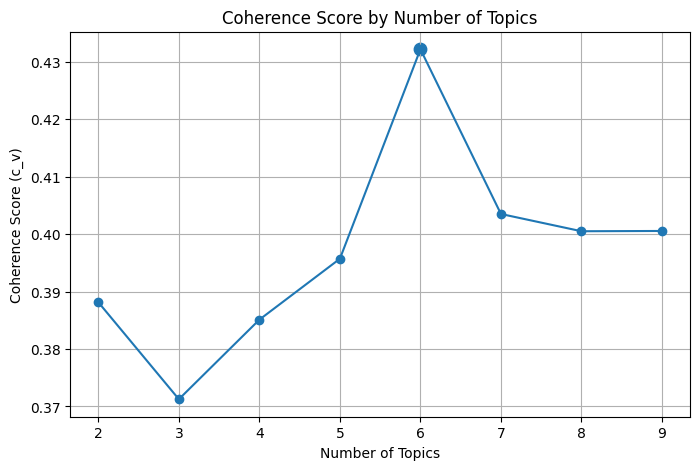

In [11]:
import matplotlib.pyplot as plt

best_k = None
best_coherence = -1

ks = list(range(2, 10))      # 2~9
coherence_scores = []        # ✅ 반드시 for문 밖에서 1번만 초기화

print("=== 토픽 수별 Coherence (c_v) ===")

for k in ks:
    lda_tmp = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=5
    )

    coherence_model = CoherenceModel(
        model=lda_tmp,
        texts=df["tokens"],
        dictionary=dictionary,
        coherence="c_v"
    )

    coherence = coherence_model.get_coherence()
    print(f"num_topics = {k} | coherence = {coherence:.4f}")

    coherence_scores.append(coherence)

    if coherence > best_coherence:
        best_coherence = coherence
        best_k = k

print(f"\n최대 Coherence: {best_coherence:.4f} (토픽 수 = {best_k})")

# -----------------------------
# ✅ 그래프 (여기부터 붙이면 됨)
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(ks, coherence_scores, marker="o")
plt.scatter(best_k, best_coherence, s=80)   # 최대값 강조
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score by Number of Topics")
plt.xticks(ks)
plt.grid(True)
plt.show()


In [12]:
num_topics = 6 # ← coherence 결과로 결정

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,
    alpha="auto"
)


In [13]:
[c for c in ["doc_topic_df", "doc_topic_dist", "doc_topics", "corpus", "lda_model"] if c in globals()]


['corpus', 'lda_model']

In [14]:
"lda_model" in globals()


True

In [15]:
print("df year unique:", df[year_col].nunique(), df[year_col].min(), df[year_col].max())
print("dt year unique:", dt["year"].nunique(), dt["year"].min(), dt["year"].max())
print("df_year rows:", df_year.shape, "years:", df_year["year"].tolist()[:10])


NameError: name 'year_col' is not defined

In [ ]:
df_year["year"].tolist()


['1974',
 '1976',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025']

In [ ]:

import plotly.express as px

# dt: (문서×토픽) + year 가 들어있는 데이터프레임이 이미 있다고 가정
# 없다면: doc_topic_df 만들고 dt["year"] 붙인 다음 dropna까지 한 dt를 쓰면 됨.
# topic_cols = ["Topic 1", ..., "Topic K"] 형태로 존재해야 함

topic_cols = [c for c in dt.columns if c.startswith("Topic ")]

# 1) 연도별 평균 토픽 비중
df_year = dt.groupby("year")[topic_cols].mean().reset_index()

# 2) long format: year, Topic, Proportion
df_long = df_year.melt(id_vars="year", var_name="Topic", value_name="Proportion")

# 3) (중요) 애니메이션에서 매년 토픽 개수/순서를 고정하려고 year-topic 조합을 전부 채움
years = np.sort(df_year["year"].unique())
topics = topic_cols

df_long = (
    df_long.set_index(["year", "Topic"])
           .reindex(pd.MultiIndex.from_product([years, topics], names=["year", "Topic"]))
           .fillna(0)
           .reset_index()
)

# 4) 표시용 포맷
df_long["year_str"] = df_long["year"].astype(int).astype(str)

# 5) Animated bubble chart
fig = px.scatter(
    df_long,
    x="Topic",
    y="Proportion",
    size="Proportion",
    color="Topic",
    animation_frame="year_str",
    animation_group="Topic",
    category_orders={"Topic": topics, "year_str": [str(y) for y in years]},
    range_y=[0, 1],
    size_max=45,
    title="Topic Share by Year (Animated Bubble Chart)"
)

fig.update_yaxes(tickformat=".0%")
fig.update_layout(showlegend=True)

fig.show()


In [ ]:

import plotly.express as px

# -----------------------------------------
# 기본 설정
# -----------------------------------------
topic_cols = [c for c in dt.columns if c.startswith("Topic ")]
years = np.sort(dt["year"].unique())

# -----------------------------------------
# 1) 연도별 토픽 비중 (평균 확률)
# -----------------------------------------
df_prop = (
    dt.groupby("year")[topic_cols]
      .mean()
      .reset_index()
      .melt(id_vars="year", var_name="Topic", value_name="Proportion")
)

# -----------------------------------------
# 2) 연도별 토픽 문서 수
#    기준: 토픽 확률 ≥ threshold
# -----------------------------------------
threshold = 0.3  # 🔧 필요하면 0.2 / 0.25 / 0.3 등 조정

dt_bin = dt.copy()
dt_bin[topic_cols] = (dt_bin[topic_cols] >= threshold).astype(int)

df_cnt = (
    dt_bin.groupby("year")[topic_cols]
          .sum()
          .reset_index()
          .melt(id_vars="year", var_name="Topic", value_name="DocCount")
)

# -----------------------------------------
# 3) 비중 + 문서수 결합
# -----------------------------------------
df_bubble = pd.merge(
    df_prop,
    df_cnt,
    on=["year", "Topic"],
    how="left"
)

# 모든 year-topic 조합 채우기 (애니메이션 안정화)
df_bubble = (
    df_bubble.set_index(["year", "Topic"])
             .reindex(pd.MultiIndex.from_product([years, topic_cols], names=["year", "Topic"]))
             .fillna(0)
             .reset_index()
)

df_bubble["year_str"] = df_bubble["year"].astype(int).astype(str)

# -----------------------------------------
# 4) Animated Bubble Chart
# -----------------------------------------
fig = px.scatter(
    df_bubble,
    x="DocCount",
    y="Proportion",
    size="DocCount",
    color="Topic",
    animation_frame="year_str",
    animation_group="Topic",
    size_max=55,
    range_y=[0, df_bubble["Proportion"].max() * 1.1],
    range_x=[0, df_bubble["DocCount"].max() * 1.1],
    category_orders={"year_str": [str(y) for y in years]},
    title=f"Topic Landscape by Year (x=Document Count, y=Proportion, threshold ≥ {threshold})"
)

fig.update_yaxes(tickformat=".0%")
fig.update_layout(
    xaxis_title="Number of Documents",
    yaxis_title="Average Topic Proportion",
    legend_title_text="Topic"
)


# 속도조절
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1200
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 800


fig.show()


In [ ]:


# =========================================
# 0) 상위 범주 매핑
# =========================================
category_map = {
    "Human-Centered Social Interaction": ["Topic 4", "Topic 5", "Topic 6"],
    "Digital Technology Driven Interaction Systems": ["Topic 1", "Topic 3"],
    "Developmental and Therapeutic Interaction": ["Topic 2"]
}

threshold = 0.3  # 문서수 계산 기준(필요하면 0.2~0.4 사이로 조정)

# dt는 아래를 포함해야 함:
# - dt["year"] (int)
# - dt["Topic 1"] ... dt["Topic K"] (float, 문서별 토픽 확률)

# =========================================
# 1) 안전 체크: 토픽 컬럼 존재 확인
# =========================================
for cat, topics in category_map.items():
    missing = [t for t in topics if t not in dt.columns]
    if missing:
        raise ValueError(f"[{cat}]에 매핑된 토픽이 dt에 없어요: {missing}")

years_sorted = sorted(dt["year"].unique())
cat_order = list(category_map.keys())

# =========================================
# 2) 연도별 '범주 비중' 계산
#    ✅ 공정 비교 버전: (연도별 토픽 평균) -> 범주 내 '평균(mean)'
#       - sum이 아니라 mean을 씀 (토픽 개수 차이 보정)
# =========================================
df_cat_prop = pd.DataFrame({"year": years_sorted})

for cat, topics in category_map.items():
    # 각 연도에서 topics의 평균 확률을 구한 뒤, 그 토픽들 평균(mean)으로 범주 비중 정의
    df_cat_prop[cat] = (
        dt.groupby("year")[topics]
          .mean()              # (year x topics) : 토픽별 연도 평균
          .mean(axis=1)        # 범주 토픽들의 평균 (토픽 개수 보정)
          .reindex(years_sorted)
          .values
    )

df_cat_prop_long = df_cat_prop.melt(
    id_vars="year", var_name="Category", value_name="Proportion"
)

# =========================================
# 3) 연도별 '범주 문서수' 계산
#    ✅ union(any): 범주 토픽 중 하나라도 threshold 이상이면 hit
# =========================================
df_cat_cnt = pd.DataFrame({"year": years_sorted})

for cat, topics in category_map.items():
    hit = (dt[topics] >= threshold).any(axis=1).astype(int)
    tmp = pd.DataFrame({"year": dt["year"].values, "hit": hit.values})
    df_cat_cnt[cat] = (
        tmp.groupby("year")["hit"]
           .sum()
           .reindex(years_sorted)
           .fillna(0)
           .astype(int)
           .values
    )

df_cat_cnt_long = df_cat_cnt.melt(
    id_vars="year", var_name="Category", value_name="DocCount"
)

# =========================================
# 4) 결합 + 애니메이션 안정화
# =========================================
df_bubble_cat = (
    pd.merge(df_cat_prop_long, df_cat_cnt_long, on=["year", "Category"], how="left")
      .fillna(0)
)

df_bubble_cat["year_str"] = df_bubble_cat["year"].astype(int).astype(str)



In [ ]:
# =========================================
# 5) 색상 고정(범례 색 빠짐 방지) + 버블 차트
# =========================================
fig = px.scatter(
    df_bubble_cat,
    x="DocCount",
    y="Proportion",
    color="Category",
    animation_frame="year_str",
    animation_group="Category",
    category_orders={
        "year_str": [str(y) for y in years_sorted],
        "Category": cat_order
    },
    color_discrete_map=color_map,
    range_x=[0, df_bubble_cat["DocCount"].max() * 1.1],
    range_y=[0, df_bubble_cat["Proportion"].max() * 1.1],
    title="Category Landscape by Year (x=DocCount, y=Category Proportion MEAN)"
)

# 🔵 모든 점을 같은 크기의 동그라미로
fig.update_traces(
    marker=dict(
        size=18,                       # 🔧 동그라미 크기 (원하면 14~22 조절)
        symbol="circle",
        line=dict(width=1, color="rgba(0,0,0,0.35)")
    )
)

fig.update_yaxes(tickformat=".0%")
fig.update_layout(
    xaxis_title="Number of Documents (Category hit)",
    yaxis_title="Average Category Proportion (mean across topics)",
    legend_title_text="Category"
)

# 애니메이션 속도 + 부드러움
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1200
fig.layout.updatemenus[0].buttons[0].args[1]["transition"] = {
    "duration": 900,
    "easing": "cubic-in-out"
}

fig.show()


In [ ]:

import plotly.graph_objects as go

# -----------------------------------------
# 0) 범주 매핑
# -----------------------------------------
category_map = {
    "Human-Centered Social Interaction": ["Topic 4", "Topic 5", "Topic 6"],
    "Digital Technology Driven Interaction Systems": ["Topic 1", "Topic 3"],
    "Developmental and Therapeutic Interaction": ["Topic 2"]
}

threshold = 0.3  # DocCount 기준

# 요청한(이미지와 같은) 색상 계열
color_map = {
    "Human-Centered Social Interaction": "#1f77b4",   # 파랑
    "Digital Technology Driven Interaction Systems": "#ff7f0e",  # 주황
    "Developmental and Therapeutic Interaction": "#2ca02c"       # 초록
}

# dt: columns = year(int), Topic 1..K(float)
# (dt가 이미 만들어져 있다고 가정)
for cat, topics in category_map.items():
    missing = [t for t in topics if t not in dt.columns]
    if missing:
        raise ValueError(f"[{cat}]에 매핑된 토픽이 dt에 없어요: {missing}")

years_sorted = sorted(dt["year"].unique())
cat_order = list(category_map.keys())

# -----------------------------------------
# 1) 연도별 토픽 평균 (year x topics)
# -----------------------------------------
topic_cols = [c for c in dt.columns if c.startswith("Topic ")]
year_topic_mean = dt.groupby("year")[topic_cols].mean().reindex(years_sorted)

# -----------------------------------------
# 2) 연도별 범주 합 S_{y,c} (sum of topic means within category)
# -----------------------------------------
df_cat_sum = pd.DataFrame({"year": years_sorted})
for cat, topics in category_map.items():
    df_cat_sum[cat] = year_topic_mean[topics].sum(axis=1).values

# -----------------------------------------
# 3) 연도별 비중 P_{y,c} = S_{y,c} / Σ_c S_{y,c}
#    -> 연도별 100% 정규화
# -----------------------------------------
row_sum = df_cat_sum[cat_order].sum(axis=1).replace(0, np.nan)

df_cat_share = df_cat_sum.copy()
df_cat_share[cat_order] = df_cat_sum[cat_order].div(row_sum, axis=0).fillna(0)

df_cat_share_long = df_cat_share.melt(
    id_vars="year", var_name="Category", value_name="Share"
)

# -----------------------------------------
# 4) 연도별 범주 문서수 (union hit)
#    -> 범주 토픽 중 하나라도 threshold 이상이면 그 범주에 "해당"으로 카운트
# -----------------------------------------
df_cat_cnt = pd.DataFrame({"year": years_sorted})
for cat, topics in category_map.items():
    hit = (dt[topics] >= threshold).any(axis=1).astype(int)
    tmp = pd.DataFrame({"year": dt["year"].values, "hit": hit.values})
    df_cat_cnt[cat] = (
        tmp.groupby("year")["hit"]
           .sum()
           .reindex(years_sorted)
           .fillna(0)
           .astype(int)
           .values
    )

df_cat_cnt_long = df_cat_cnt.melt(
    id_vars="year", var_name="Category", value_name="DocCount"
)

# -----------------------------------------
# 5) 결합 (Plotly용)
# -----------------------------------------
df_plot = (
    pd.merge(df_cat_share_long, df_cat_cnt_long, on=["year", "Category"], how="left")
      .fillna(0)
)
df_plot["year_str"] = df_plot["year"].astype(int).astype(str)

# -----------------------------------------
# 6) Animated Bubble: x=DocCount, y=Share
#    - 버블 크기: DocCount (값에 따라 변화)
#    - 범례 마커 크기: 고정 (더미 trace로 처리)
# -----------------------------------------
fig = px.scatter(
    df_plot,
    x="DocCount",
    y="Share",
    size="DocCount",
    color="Category",
    animation_frame="year_str",
    animation_group="Category",
    color_discrete_map=color_map,
    category_orders={"year_str": [str(y) for y in years_sorted], "Category": cat_order},
    range_x=[0, df_plot["DocCount"].max() * 1.1],
    range_y=[0, 1],
    size_max=55,
    title=f"Category Landscape by Year (x=DocCount, y=Year-normalized Share, threshold ≥ {threshold})"
)

# (가독성) 실제 점 테두리
fig.update_traces(marker=dict(line=dict(width=1, color="rgba(0,0,0,0.35)")))

# ✅ 6-1) px가 만든 "기본 범례" 전부 끄기 (현재 trace)
for tr in fig.data:
    tr.showlegend = False

# ✅ 6-2) 애니메이션 프레임 안 trace들도 범례 끄기 (중복 해결 핵심)
if hasattr(fig, "frames") and fig.frames:
    for fr in fig.frames:
        for tr in fr.data:
            tr.showlegend = False

# ✅ 6-3) 범례 전용 더미 trace 추가 (고정 크기 마커)
legend_marker_size = 14
for cat in cat_order:
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode="markers",
            marker=dict(
                size=legend_marker_size,
                color=color_map[cat],
                symbol="circle",
                line=dict(width=1, color="rgba(0,0,0,0.35)")
            ),
            name=cat,
            showlegend=True,
            hoverinfo="skip"
        )
    )

# 축/레이아웃
fig.update_yaxes(tickformat=".0%")
fig.update_layout(
    xaxis_title="Number of Documents (Category hit)",
    yaxis_title="Category Share within Year (normalized to 100%)",
    legend_title_text="Category"
)

# 속도 + 부드러운 전환
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1200
fig.layout.updatemenus[0].buttons[0].args[1]["transition"] = {
    "duration": 900,
    "easing": "cubic-in-out"
}

fig.show()

# (선택) 저장
os.makedirs("outputs", exist_ok=True)
fig.write_html("outputs/category_landscape_year_normalized_share.html")
